<a href="https://colab.research.google.com/github/Soyoung-n/prac_class/blob/main/mid.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

분석목적: 상환 기간의 매출을 예측하여 신용 점수가 낮거나 담보를 가지지 못하는 우수 상점들에 금융 기회를 제공

분석방향: 2016년 6월부터 2019년 2월 28일까지의 카드 거래 데이터를 활용해 2019년 3월부터 5월까지 각 상점별 3개월 간 총매출 예측


1. Library & Load Data

In [ ]:
import itertools
import pandas as pd
import numpy as np
import datetime
from datetime import datetime as dt
from tqdm import tqdm

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sbs
import calendar

import rpy2.robjects as ro
import rpy2
from rpy2.robjects import pandas2ri
from tqdm import tqdm
from rpy2.robjects.packages import importr
from rpy2.robjects.conversion import localconverter

#시계열
from statsmodels.tsa.arima_model import ARIMA
from dateutil.relativedelta import relativedelta
from statsmodels.tsa.api import SimpleExpSmoothing, Holt, ExponentialSmoothing

#LSTM
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.layers import Embedding
from keras.layers import LSTM


import warnings
warnings.filterwarnings('ignore')

In [ ]:
from google.colab import drive 
drive.mount('/content/gdrive/')

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


In [ ]:
df_train = pd.read_csv('/content/gdrive/MyDrive/funda_train.csv')
df_sub = pd.read_csv('/content/gdrive/My Drive/submission.csv')

-데이터 설명

store_id : 상점의 고유 아이디

card_id : 사용한 카드의 고유 아이디

card_company : 비식별화된 카드 회사

transacted_date : 거래 날짜

transacted_time : 거래 시간

installment_term : 할부 개월 수

region : 상점의 지역

type_of_business : 상점의 업종

amount : 거래액

In [ ]:
df_train.head(5)

,store_id,card_id,card_company,transacted_date,transacted_time,installment_term,region,type_of_business,amount
0,0,0,b,2016-06-01,13:13,0,NaN,기타 미용업,1857.142857
1,0,1,h,2016-06-01,18:12,0,NaN,기타 미용업,857.142857
2,0,2,c,2016-06-01,18:52,0,NaN,기타 미용업,2000.000000
3,0,3,a,2016-06-01,20:22,0,NaN,기타 미용업,7857.142857
4,0,4,c,2016-06-02,11:06,0,NaN,기타 미용업,2000.000000


2. Data Cleansing

In [ ]:
#1) 시계열 분석 적용 위해서 date를 index로 설정
df_train['transacted_date']= pd.to_datetime(df_train['transacted_date'])
df_train= df_train.set_index('transacted_date')
df_train.head(5)

,store_id,card_id,card_company,transacted_time,installment_term,region,type_of_business,amount
transacted_date,,,,,,,,
2016-06-01,0,0,b,13:13,0,NaN,기타 미용업,1857.142857
2016-06-01,0,1,h,18:12,0,NaN,기타 미용업,857.142857
2016-06-01,0,2,c,18:52,0,NaN,기타 미용업,2000.000000
2016-06-01,0,3,a,20:22,0,NaN,기타 미용업,7857.142857
2016-06-02,0,4,c,11:06,0,NaN,기타 미용업,2000.000000


In [ ]:
#데이터 결측값 확인
df_train.isnull().sum()

store_id                  0
card_id                   0
card_company              0
transacted_time           0
installment_term          0
region              2042766
type_of_business    3952609
amount                    0
dtype: int64

In [ ]:
#2) 예측 해야하는 것은 3개월인데, 시간이 포함되어있음-> 월단위로 resampling
#2-1. 일별 resampling
def resample_day(train_df) :
  df_day= pd.DataFrame()
    
  for i in train_df.store_id.unique() :
    df_str= train_df[train_df.store_id==i] #상점별/ 일별로 계산

    sum_cols= df_str[['installment_term','amount']].resample('d').sum() #매출액, 할부개월 합계
    cnt_cols= df_str['card_id'].resample(rule='d').count().rename('num_of_pay') #일별 거래횟수
    revisit_idx= df_str.card_id.value_counts().reset_index().query("card_id > 2")["index"].values 
    cnt_revisit= df_str[df_str.card_id.isin(revisit_idx)].card_id.resample(rule='d').count().rename('num_of_revisit') #card_id가 2 이상인 단골 수 

    df_a_day= pd.concat([cnt_cols,cnt_revisit,sum_cols],axis=1)

    df_a_day.insert(0, 'store_id', i)
    df_a_day.insert(4, 'region', df_str[df_str.store_id== i].region.unique()[0])
    df_a_day.insert(5, 'type_of_business', df_str[df_str.store_id==i].type_of_business.unique()[0])

    df_day= pd.concat([df_day, df_a_day],axis=0)
  
  df_day.insert(1,'day_of_week', df_day.index.dayofweek) #요일 변수
  df_day.insert(2,'work_day', df_day.day_of_week.replace({0:1,2:1,3:1,4:1,5:0,6:0}).values) #평일/휴일 구분 변수
  df_day.num_of_revisit.fillna(0, inplace=True)

  return df_day

In [ ]:
#df_train에 적용
df_daily= resample_day(df_train)

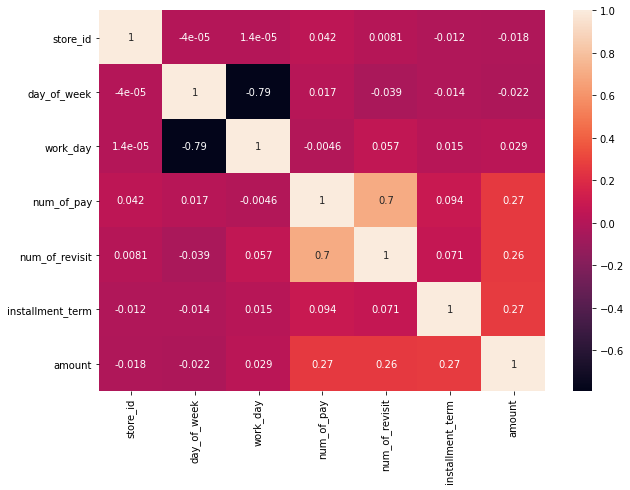

In [ ]:
#변수 간 상관관계 확인
fig, ax= plt.subplots()
fig.set_size_inches(10,7)
sbs.heatmap(df_daily.corr(), annot=True)
#단골의 재방문 횟수와 결제 횟수 간 상관성 존재

In [ ]:
#2-2. 월별 resampling
def resample_month(train_df) :
  df_mon= pd.DataFrame()
  sum_cols= ['num_of_pay','num_of_revisit','installment_term','amount']
  
  for i in train_df.store_id.unique() :
    df_str= train_df[train_df.store_id==i] 

    #resample 시 두 번째 데이터부터 적용-> 2016/06/01과 2019/2/28 데이터 사용 못 함(?)
    prev_date= pd.date_range(start= (df_str.index[0]-relativedelta(months=1)), end= (df_str.index[0]-relativedelta(months=1)))
    aft_date= pd.date_range(start= (df_str.index[-1]+relativedelta(months=1)), end= (df_str.index[-1]+relativedelta(months=1)))
    df_str= pd.concat([pd.DataFrame(index=prev_date),df_str,pd.DataFrame(index=aft_date)], axis=0)

    df_str.loc[dt.strftime(df_str.index[0], "%Y-%m"),:]=1
    df_str.loc[dt.strftime(df_str.index[-1], "%Y-%m"),:]=1

    tot_day= df_str[df_str.amount!=0].day_of_week.resample(rule='m').count().rename('total_week') #한 달 동안 결제가 이루어진 날의 수
    wok_day= df_str[df_str.amount!=0].work_day.resample(rule='m').sum().rename('total_work_day') #한 달 동안 결제가 이루어진 평일의 수
    
    #앞서 추가했던 행 삭제
    tot_day= tot_day.drop([tot_day.index[0], tot_day.index[-1]], axis=0)
    wok_day= wok_day.drop([wok_day.index[0], wok_day.index[-1]], axis=0)
    df_str=  df_str.drop([df_str.index[0], df_str.index[-1]], axis=0)

    df= pd.concat([tot_day, wok_day, df_str[sum_cols].resample(rule="m").sum()], axis=1)
 
    df.insert(0, 'store_id', i)
    df.insert(6, 'region', df_str.region.values[0])
    df.insert(7, 'type_of_business', df_str.type_of_business.values[0])

    df_mon= pd.concat([df_mon, df], axis=0)

  return df_mon

In [ ]:
#일별 resampling된 df_daily 데이터에 적용
df_monthly=resample_month(df_daily)

In [ ]:
#데이터 결측값 확인
df_monthly.isnull().sum()
#region과 type_of_business는 na 너무 많이 존재-> 삭제
df_monthly= df_monthly.drop(['region','type_of_business'], axis=1)
df_monthly.isnull().sum()

store_id            0
total_week          0
total_work_day      0
num_of_pay          0
num_of_revisit      0
installment_term    0
amount              0
dtype: int64

3. EDA

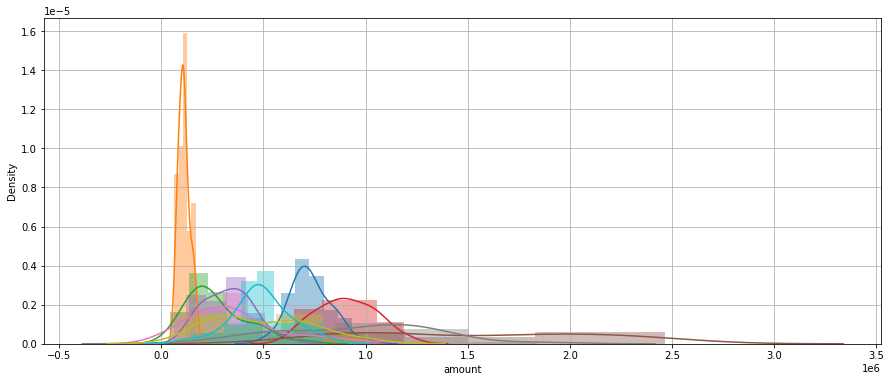

In [ ]:
plt.figure(figsize= (15,6))
for i in df_monthly.store_id.unique()[:10]:
  sbs.distplot(df_monthly[df_monthly.store_id == i].amount)

plt.grid()
plt.show()
#대부분의 상점들의 p-value가 0.05를 넘기므로 정상성을 만족하기 위해 차분 필요

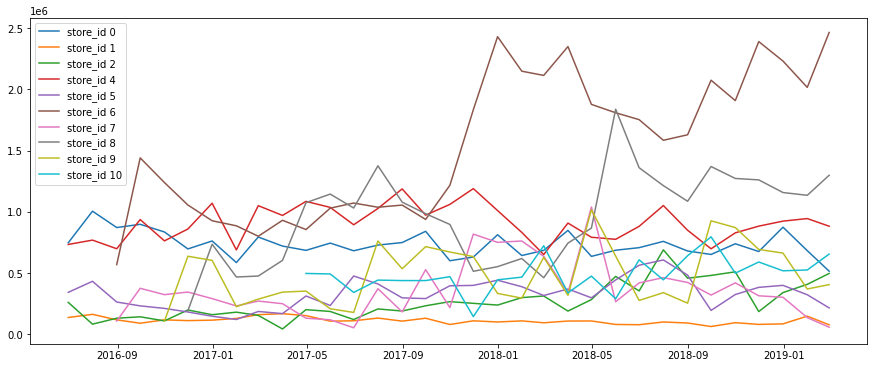

In [ ]:
# store_id별 매출 추이
plt.figure(figsize= (15,6))
for i in df_monthly.store_id.unique()[:10]:
  plt.plot(df_monthly[df_monthly.store_id==i].index, df_monthly[df_monthly.store_id==i].amount, label='store_id {}'.format(i))
plt.legend()

#store_id별로 매출 양상이 다르다-> 상점별 개별화된 모델 피팅 필요

4. Model Fitting

4-1.Exponential Moving Average

In [ ]:
#2019년 3월부터 5월까지 매출액의 합을 지수이동평균 사용해 예측
def emv_sub(df,n):
    mon3 = pd.DataFrame(index=pd.to_datetime(['2019-03-31', '2019-04-30', '2019-05-31']))
    df_emv= pd.DataFrame(columns=['store_id','amount'])

    for i in df.store_id.unique():
        df_set = pd.DataFrame(df[df.store_id == i].amount)
        emv_train = pd.concat([df_set, mon3], axis=0)
        sub = emv_train.amount.ewm(span=n).mean()['2019-03':].sum() #최근 n개의 데이터에 높은 가중치 부여
        df_emv.loc[i,'store_id']=i
        df_emv.loc[i,'amount']= sub
        
    return df_emv

In [ ]:
ema_sub = np.array([])

for i in tqdm(range(4, 7)):
    ema_sub = emv_sub(df_monthly, i)
    ema_sub.to_csv(f'/content/gdrive/MyDrive/emv_submission_{i}.csv',index=False)

100%|██████████| 3/3 [00:26<00:00,  8.97s/it]


In [ ]:
ema_sub

,store_id,amount
0,0,2.0045e+06
1,1,288643
2,2,1.24782e+06
4,4,2.66623e+06
5,5,971897
...,...,...
2132,2132,1.91688e+06
2133,2133,459567
2134,2134,366480
2135,2135,1.53795e+06


4emv결과 : 770667.89531

5emv결과 : 767498.55142

6emv결과 : 770414.02703

4-2.ARIMA

In [ ]:
#para 정의
p = list(range(0, 6))
d = [0, 1, 2]
q = list(range(0, 6))

pdq = list(itertools.product(p, d, q))

In [ ]:
#최적의 parameter와 그에 따른 최적의 모델을 피팅
arima_pred= np.array([])
for i in tqdm(df_monthly.store_id.unique()):
  df_str= df_monthly[df_monthly.store_id== i]

  best_score= 10000000000
  best_para= 0
  for para in pdq :
    try:
      arm_model= ARIMA(df_str.amount.values, order=para)
      result= arm_model.fit()

      if result.aic < best_score :
        best_score= result.aic
        best_para= para
    except:
      continue

  arm_model= ARIMA(df_str.amount.values, order= best_para) #최적의 parameter 갖는 매출액 데이터의 arima 모델 찾기
  arm_result= arm_model.fit() #피팅
  arm_pred= arm_result.forecast(3)[0] #3개월 후 예측

  arima_pred= np.concatenate((arima_pred, np.array([arm_pred.sum()])))
  #모델링에 시간이 어마어마하게 소요돼서 중간에 멈췄습니다... 

 30%|██▉       | 588/1967 [4:45:43<9:15:43, 24.18s/it] 

In [ ]:
arima_sum= pd.DataFrame({'store_id' : df_sub.store_id, 'amount' : arima_pred})
arima_sum.to_csv('/content/gdrive/MyDrive/arm_submission.csv'.csv', index=False)

4-3. LSTM (Deep Neural Network)

In [ ]:
#신경망의 빠른 학습 위해 정규화
dl_month= df_monthly.copy()

normalize = np.array([])
for i in dl_month.store_id.unique():
    df_str = dl_month[dl_month.store_id == i].amount.values
    set_arr = np.array([(float(i + 1) / float(df_str[0] + 1))-1 for i in df_str]) # store_id가 0인 경우 대비한 정규화
    normalize = np.concatenate((normalize, set_arr))

dl_month.insert(7, 'normalize', normalize)

In [ ]:
#Warnings 무시
import tensorflow as tf
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

In [ ]:
for i in dl_month.store_id.unique()[:20]:
    df_str = dl_month[dl_month.store_id == i]

    dl_x = df_str.index.values.astype(np.float32)
    dl_y = df_str.normalize 

    dl_x = dl_x.reshape(len(dl_x), 1) #데이터를 RNN 형태로 reshape
    dl_x = np.reshape(dl_x, (dl_x.shape[0], 1, dl_x.shape[1]))

    # 모델 생성
    model = Sequential() #Sequential Model
    model.add(LSTM(input_dim=1, units =50, input_shape=(len(dl_x), 1), return_sequences=True)) #입력층 설정
    model.add(Dropout(0.2)) #과적합 방지 위해

    model.add(LSTM(100, return_sequences=False)) #Dense layer에 들어가기 전이므로 false
    model.add(Dropout(0.2))

    model.add(Dense(1, activation= "relu")) #output이 1 #활성화 함수 relu 사용
    model.compile(loss='mean_squared_error', optimizer='adam')

  # 모델 학습
    model.fit(dl_x, dl_y, epochs=100, validation_split=0.05, verbose=0)

    target_date = pd.date_range(start=df_str.index[-1], end=dt.strptime('2019-05-31', "%Y-%m-%d"), freq='m')[1:]
    target_date = target_date.values.reshape(len(target_date), 1)
    target_date = np.reshape(target_date, (target_date.shape[0], 1, target_date.shape[1]))

    lstm_pred = model.predict(target_date.astype(np.float32))

    print("Value of store_id {} prediction :".format(i),lstm_pred.reshape(len(lstm_pred),))

# 대다수가 예측값을 0으로 출력 -> denormalization하면 첫 번째 관측값이 됨
# 탈락! 

Value of store_id 0 prediction : [0. 0. 0.]
Value of store_id 1 prediction : [0. 0. 0.]
Value of store_id 2 prediction : [0. 0. 0.]
Value of store_id 4 prediction : [0. 0. 0.]
Value of store_id 5 prediction : [0. 0. 0.]
Value of store_id 6 prediction : [1.5768577 1.5768577 1.5768577]
Value of store_id 7 prediction : [2.5141392 2.5141392 2.5141392]
Value of store_id 8 prediction : [3.8230565 3.8230565 3.8230565]
Value of store_id 9 prediction : [3.5888195 3.5888195 3.5888195]
Value of store_id 10 prediction : [0. 0. 0.]
Value of store_id 11 prediction : [10.593419 10.593419 10.593419]
Value of store_id 12 prediction : [0.7780618 0.7780618 0.7780618]
Value of store_id 13 prediction : [0. 0. 0.]
Value of store_id 14 prediction : [0. 0. 0.]
Value of store_id 15 prediction : [3.4393947 3.4393947 3.4393947]
Value of store_id 16 prediction : [0. 0. 0.]
Value of store_id 17 prediction : [0.0867673 0.0867673 0.0867673]
Value of store_id 18 prediction : [8.570716 8.570716 8.570716]
Value of stor

4-4. Ensemble Model

In [ ]:
utils = importr('utils') ##utils 패키지 import
utils.install_packages('forecast') 
utils.install_packages('forecastHybrid') 

In [ ]:
pandas2ri.activate()

#R function str형식으로 저장
hybridModel= """function(data){
    library(forecast)
    library(forecastHybrid) #앙상블 시계열 모델 구축 패키지지
    para= ndiffs(data)
    hb_model= hybridModel(data, model="aes", a.arg= list(max.p=2, d=para), weight="equal") #a :auto.arima, e:ets, s:stlm 앙상블
    forecast= forecast(hb_model, h=3) #3시점 후 예측
    df= data.frame(forecast$mean)
    colnames(df)= c("amount")
    df
}
"""

hybridModel=ro.r(hybridModel)
ts= ro.r('ts')
c= ro.r('c')

final_pred=[]
for i in df_monthly.store_id.unique():
    pred=[]
    
    df_str= df_monthly[df_monthly['store_id']==i]
    start_year= int(dt.strftime(df_str.index[0],"%Y")) #영업 시작 년도
    start_month= int(dt.strftime(df_str.index[0],"%m")) #영업 시작 월
        
    data= ts(df_str.amount,start= c(start_year,start_month),frequency=12) #R의 ts함수로 time series데이터로 변환
    forecast= hybridModel(data) 

    with localconverter(ro.default_converter + pandas2ri.converter): #pandas 데이터를 r로 변경
      r_from_forecast = ro.conversion.py2rpy(forecast)

    final_pred.append(np.sum(pandas2ri.rpy2py(r_from_forecast).values)) #3개월 매출을 합산,final_pred에 추가

In [ ]:
df_sub['amount']=final_pred
df_sub.to_csv('/content/gdrive/MyDrive/en_submission.csv', index=False)

In [ ]:
df_sub

,store_id,amount
0,0,2.033535e+06
1,1,2.882500e+05
2,2,1.268507e+06
3,4,2.688158e+06
4,5,6.811035e+05
...,...,...
1962,2132,2.190445e+06
1963,2133,5.455416e+05
1964,2134,2.644456e+05
1965,2135,1.689655e+06


en_sub 결과 : 776039.46893

5. Conclusion

모델링 결과, 최근 5개월의 데이터에 높은 가중치를 부여하는 지수이동평균 모델이 가장 낮은 767498.55142 점수를 받으며 최적의 모델로 선정

*ARIMA 모델의 경우, 각 상점별로 모델 피팅하는 과정에서 시간 너무 많이 소요 -> 과제 이후에도 계속 시도해 볼 계획